# Visualize Distributions of Data

## Collect the Raw Power Data for All Conditions into Single Structure

In [1]:
import numpy as np
from ipywidgets import interact
import pylab as plt
import seaborn as sns
import glob

sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')

% matplotlib inline

raw_power = {}

conditions = ["Open", "Closed", "Brain"]

for condition in conditions:

    fnames = sorted(glob.glob("./power/*%s*_raw_power.npz" %(condition)))

    tmp = np.load(fnames[0])
    times = tmp['times']
    chs = tmp['chs']
    freqs = tmp['freqs']

    #######################################
    # Collect Date Data Within Conditions #
    #######################################

    power = [np.load(f)['data'] for f in fnames]
    raw_power[condition] = np.concatenate(power, axis=0)
    
print("Done!")

Done!


## Visualize the Raw Power Data

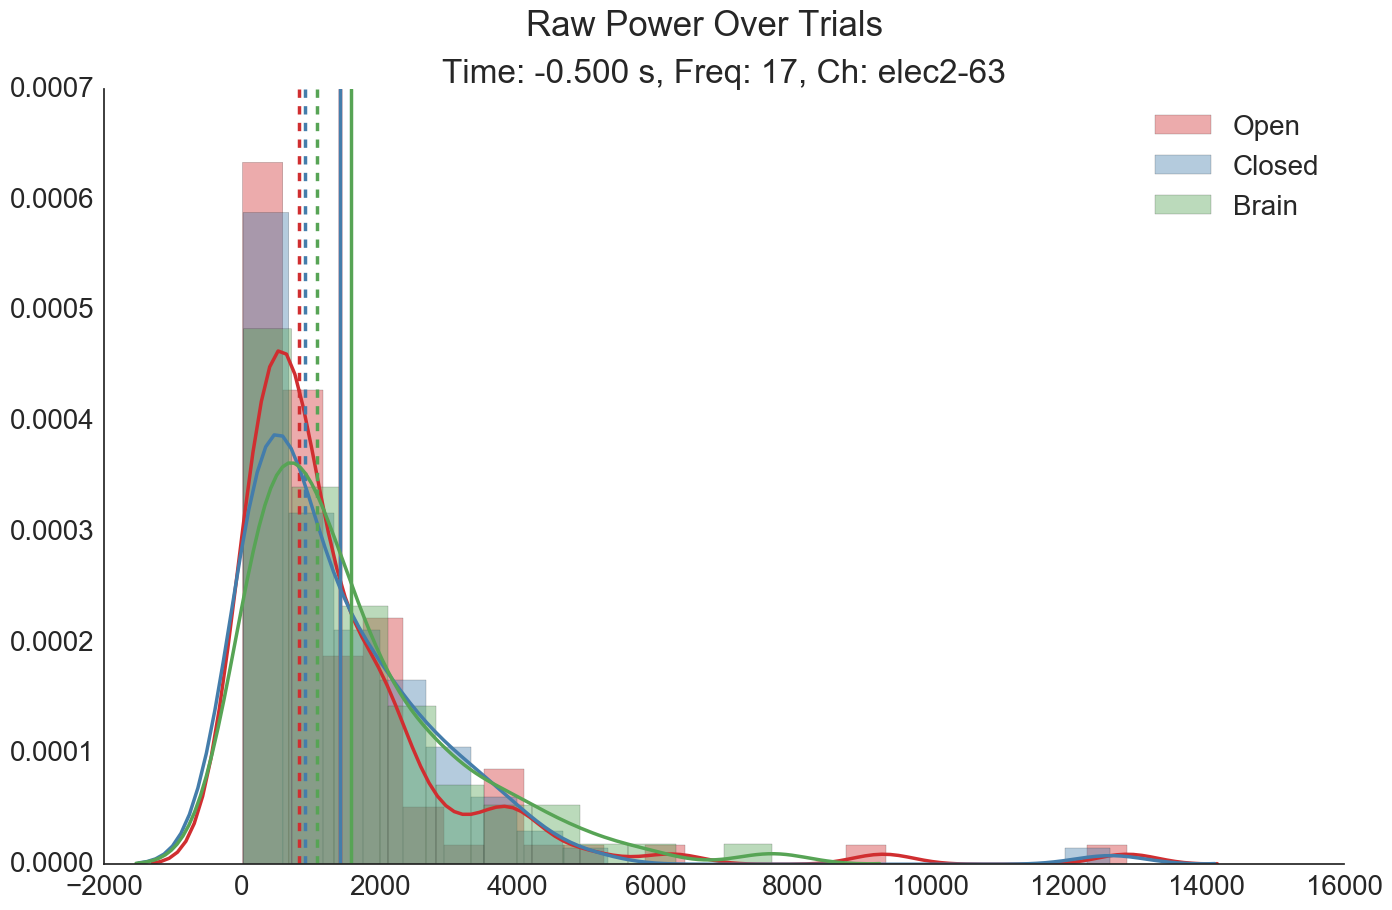

<function __main__.hist_raw>

In [2]:
def hist_raw(time_ix, ch, freq):
    
    freq_ix = list(freqs).index(freq) 
    ch_ix = list(chs).index(ch)
    
    f, ax = plt.subplots(1, 1, figsize= (16, 10))
    f.suptitle("Raw Power Over Trials", fontsize=25, y=.98)
    
    for col, cond in zip(COLORS[:3], conditions):
    
        data = raw_power[cond][:, ch_ix, freq_ix, time_ix].squeeze()
    
        sns.distplot(data, ax=ax, color=col)
        ax.set_title("Time: %.3f s, Freq: %s, Ch: %s" %(times[time_ix], freq, ch))
        ax.axvline(data.mean(), color=col, label='_nolegend_')
        ax.axvline(np.median(data), linestyle='--', color=col, label='_nolegend_')
    
    sns.despine()
    plt.legend(conditions)
    plt.show()
    
interact(hist_raw, time_ix=(0, len(times)-1, 1), ch=list(chs), freq=(freqs[0], freqs[-1], 1))

## Visualize the Log Transformed Raw Power Data

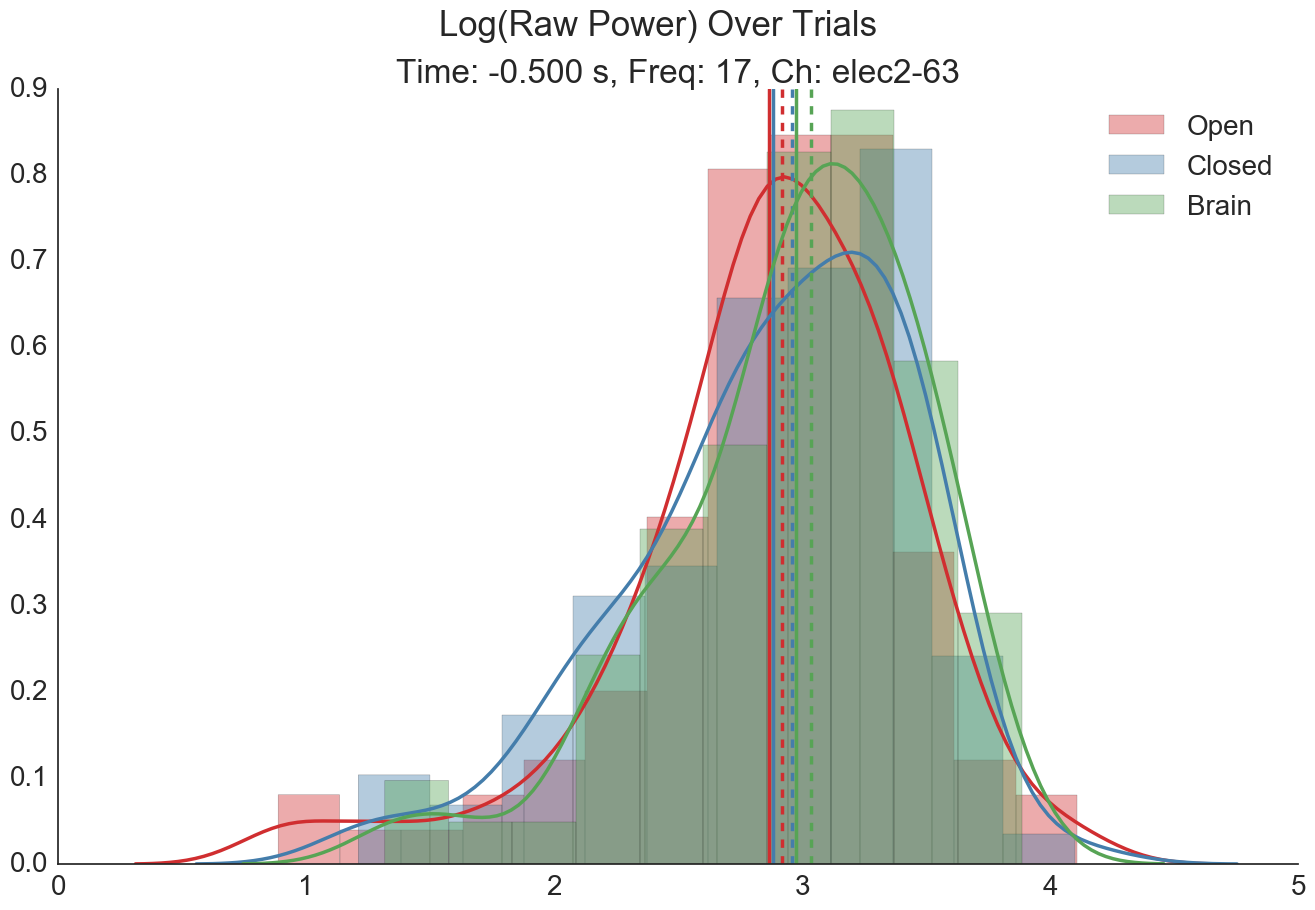

<function __main__.hist_log_raw>

In [3]:
def hist_log_raw(time_ix, ch, freq):
    
    freq_ix = list(freqs).index(freq) 
    ch_ix = list(chs).index(ch)
    
    f, ax = plt.subplots(1, 1, figsize= (16, 10))
    f.suptitle("Log(Raw Power) Over Trials", fontsize=25, y=.98)
    
    for col, cond in zip(COLORS[:3], conditions):
    
        data = np.log10(raw_power[cond][:, ch_ix, freq_ix, time_ix].squeeze())
    
        sns.distplot(data, ax=ax, color=col)
        ax.set_title("Time: %.3f s, Freq: %s, Ch: %s" %(times[time_ix], freq, ch))
        ax.axvline(data.mean(), color=col, label='_nolegend_')
        ax.axvline(np.median(data), linestyle='--', color=col, label='_nolegend_')
    
    sns.despine()
    plt.legend(conditions)
    plt.show()
    
interact(hist_log_raw, time_ix=(0, len(times)-1, 1), ch=list(chs), freq=(freqs[0], freqs[-1], 1))

## Baseline Normalize the Data

In [4]:
normalized_power = {}
conditions = ["Open", "Closed", "Brain"]

baseline = (-5, -1)

for condition in conditions:
    
        print("Normalizing Power for Condition: %s" %(condition))

        ###################
        # Normalize Power # 
        ###################

        # Power Normalizations are done according to Grandchamp & Delorme, 2011
        # Normalizations are done within condition, within electrode, within frequency

        # First Normalize Each Trial by Median of Entire Trial
        trial_bl = np.median(raw_power[condition], axis=-1)[:, :, :, np.newaxis]
        trial_norm_power = raw_power[condition] / trial_bl

        # Then Median & Normalize Within Condition by Median of Pre-Stim Baseline Period
        cond_power = np.median(trial_norm_power, axis=0)
        cond_bl_mask = np.where(np.logical_and(times >= baseline[0], times <= baseline[1]))
        cond_bl = np.median(cond_power[:, :, cond_bl_mask].squeeze(), axis=-1)[:, :, np.newaxis]
        cond_norm_power = cond_power / cond_bl

        # Finally, Log Transform & Scale for Decibels 
        normalized_power[condition] = 10 * np.log10(cond_norm_power)

print("Done!")

Normalizing Power for Condition: Open
Normalizing Power for Condition: Closed
Normalizing Power for Condition: Brain
Done!


## Visualize Baseline Normalized Power Across Frequencies Within a Band

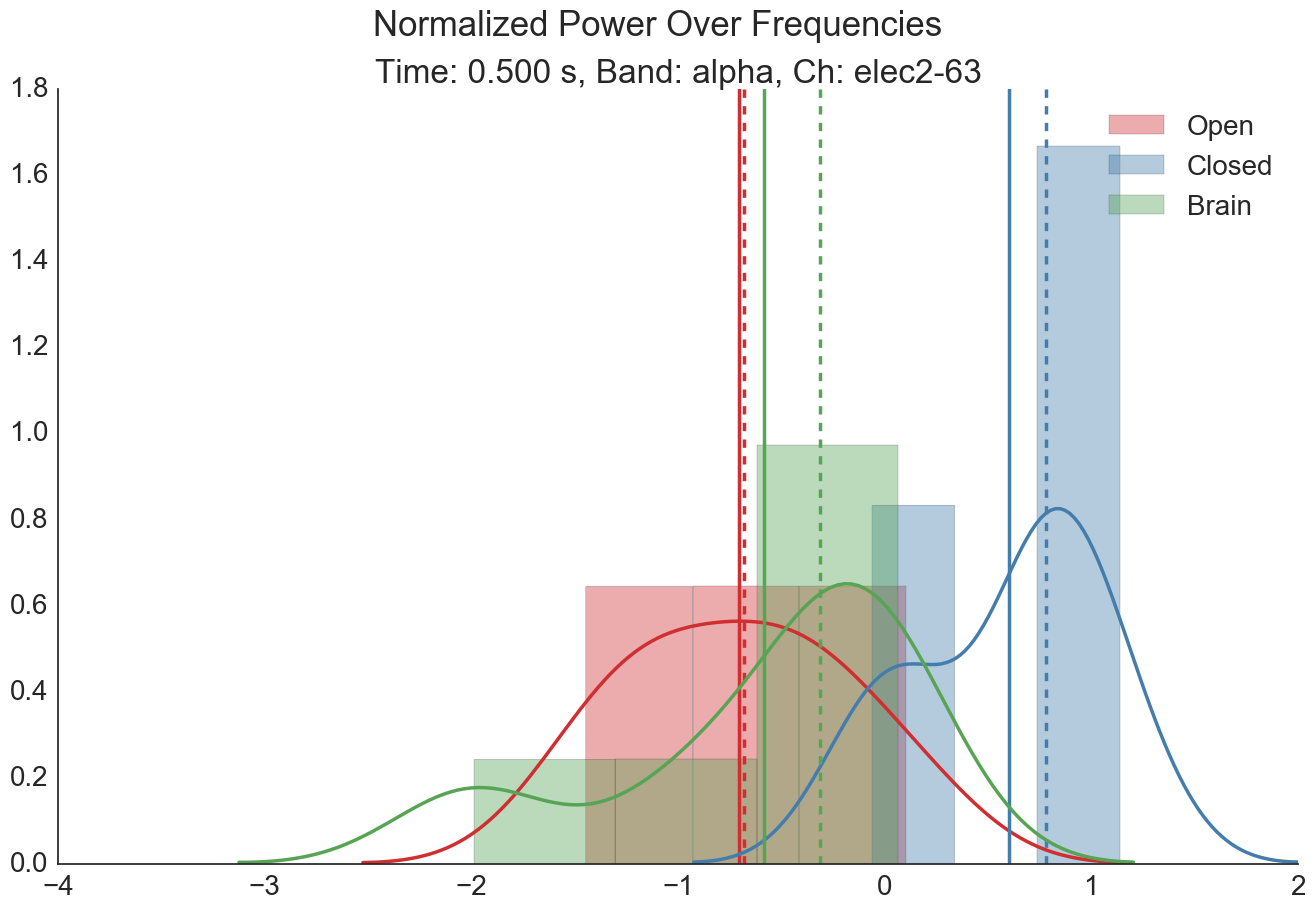

<function __main__.hist_normalized_power>

In [5]:
def hist_normalized_power(time_ix, ch, band):
    
    freqs = np.arange(5, 31)
    bands = {"alpha":(8, 15), "theta": (4, 8), "beta": (15, 30)}
    freq_mask = np.where(np.logical_and(freqs > bands[band][0], freqs < bands[band][1]))
    
    ch_ix = list(chs).index(ch)
    
    f, ax = plt.subplots(1, 1, figsize= (16, 10))
    f.suptitle("Normalized Power Over Frequencies", fontsize=25, y=.98)
    
    for col, cond in zip(COLORS[:3], conditions):
        
        data = normalized_power[cond][:, freq_mask, :].squeeze()
        data = data[ch_ix, :, time_ix].squeeze()
    
        sns.distplot(data, ax=ax, color=col)
        ax.set_title("Time: %.3f s, Band: %s, Ch: %s" %(times[time_ix], band, ch))
        ax.axvline(data.mean(), color=col, label='_nolegend_')
        ax.axvline(np.median(data), linestyle='--', color=col, label='_nolegend_')
    
    sns.despine()
    plt.legend(conditions)
    plt.show()
    
interact(hist_normalized_power, time_ix = (0, normalized_power["Closed"].shape[-1], 1), ch = list(chs), band = ["alpha", "beta", "theta"])

## Visualize Band Power Across Channels Within a Spotlight 

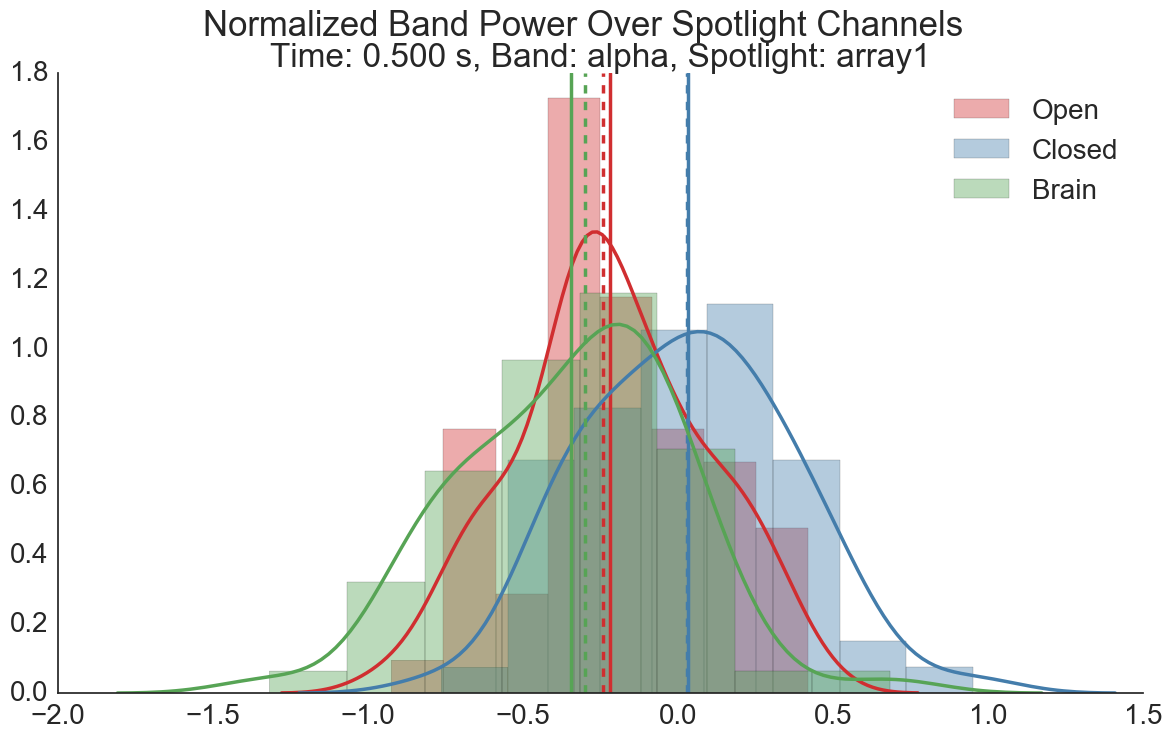

In [12]:
def hist_band_power(time_ix, spotlight, band):
    
    freqs = np.arange(5, 31)
    bands = {"alpha":(8, 15), "theta": (4, 8), "beta": (15, 30)}
    freq_mask = np.where(np.logical_and(freqs > bands[band][0], freqs < bands[band][1]))
    
    
    spotlight1 = ['elec1-74', 'elec1-75', 'elec1-76', 'elec1-77',
              'elec1-82', 'elec1-85',
              'elec1-90', 'elec1-91', 'elec1-92', 'elec1-93']
    spot1_ix = [ix for ix in np.arange(len(chs)) if chs[ix] in spotlight1]

    spotlight2 = spotlight1 + ['elec1-65', 'elec1-66', 'elec1-67', 'elec1-68', 'elec1-69', 'elec1-70',
                           'elec1-73', 'elec1-78', 'elec1-81', 'elec1-86', 'elec1-89', 'elec1-94',
                           'elec1-97', 'elec1-98', 'elec1-99', 'elec1-100', 'elec1-101', 'elec1-102']
    spot2_ix = [ix for ix in np.arange(len(chs)) if chs[ix] in spotlight2]
    
    arr1_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']
    arr2_ix = [ix for ix in np.arange(len(chs)) if 'elec2' in chs[ix]]
    
    spot_dict = {"d=1": spot1_ix, "d=2": spot2_ix, 'array1': arr1_ix, 'array2': arr2_ix}
    spot_ix = spot_dict[spotlight]
    
    
    f, ax = plt.subplots(1, 1, figsize= (14, 8))
    f.suptitle("Normalized Band Power Over Spotlight Channels", fontsize=25, y=.98)
    
    for col, cond in zip(COLORS[:3], conditions):
        
        data = normalized_power[cond][:, freq_mask, :].squeeze().mean(axis=1)
        data = data[spot_ix, time_ix].squeeze()
    
        sns.distplot(data, ax=ax, color=col)
        ax.set_title("Time: %.3f s, Band: %s, Spotlight: %s" %(times[time_ix], band, spotlight))
        ax.axvline(data.mean(), color=col, label='_nolegend_')
        ax.axvline(np.median(data), linestyle='--', color=col, label='_nolegend_')
    
    sns.despine()
    plt.legend(conditions)
    plt.show()
    
interact(hist_band_power, time_ix = (0, normalized_power["Closed"].shape[-1], 1), spotlight = ["d=1", "d=2", "array1", "array2"], band = ["alpha", "beta", "theta"])

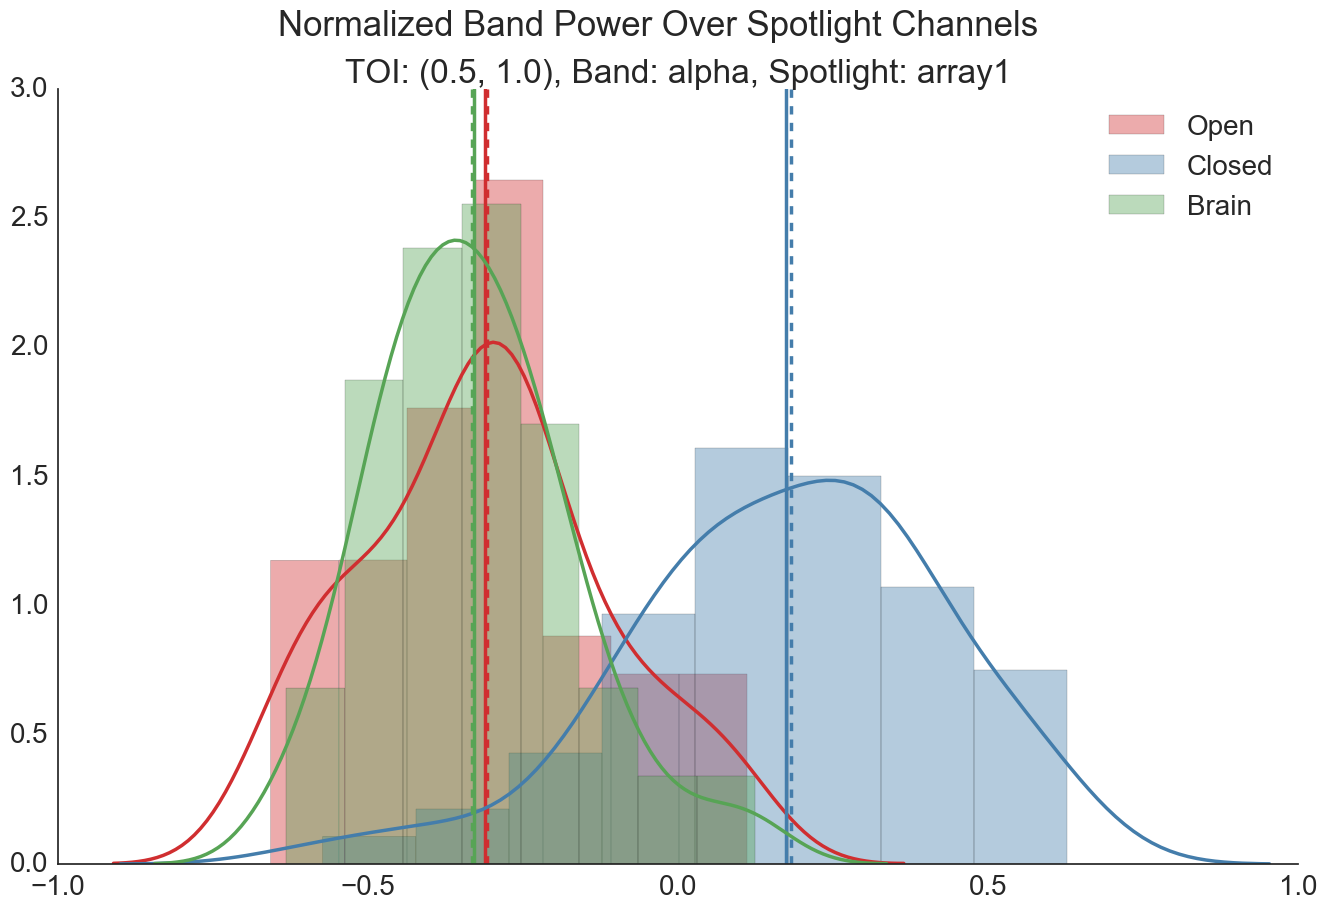

In [13]:
def hist_toi_power(toi_start, toi_end, spotlight, band):
    
    toi = (toi_start, toi_end)
    toi_mask = np.where(np.logical_and(times >= toi[0], times <= toi[1]))
    
    freqs = np.arange(5, 31)
    bands = {"alpha":(8, 15), "theta": (4, 8), "beta": (15, 30)}
    freq_mask = np.where(np.logical_and(freqs > bands[band][0], freqs < bands[band][1]))
    
    spotlight1 = ['elec1-74', 'elec1-75', 'elec1-76', 'elec1-77',
              'elec1-82', 'elec1-85',
              'elec1-90', 'elec1-91', 'elec1-92', 'elec1-93']
    spot1_ix = [ix for ix in np.arange(len(chs)) if chs[ix] in spotlight1]

    spotlight2 = spotlight1 + ['elec1-65', 'elec1-66', 'elec1-67', 'elec1-68', 'elec1-69', 'elec1-70',
                           'elec1-73', 'elec1-78', 'elec1-81', 'elec1-86', 'elec1-89', 'elec1-94',
                           'elec1-97', 'elec1-98', 'elec1-99', 'elec1-100', 'elec1-101', 'elec1-102']
    spot2_ix = [ix for ix in np.arange(len(chs)) if chs[ix] in spotlight2]
    
    arr1_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']
    arr2_ix = [ix for ix in np.arange(len(chs)) if 'elec2' in chs[ix]]
    
    spot_dict = {"d=1": spot1_ix, "d=2": spot2_ix, 'array1': arr1_ix, 'array2': arr2_ix}
    spot_ix = spot_dict[spotlight]
    
    f, ax = plt.subplots(1, 1, figsize= (16, 10))
    f.suptitle("Normalized Band Power Over Spotlight Channels", fontsize=25, y=.98)
    
    for col, cond in zip(COLORS[:3], conditions):
        
        data = normalized_power[cond][:, freq_mask, :].squeeze().mean(axis=1)
        data = data[spot_ix, :].squeeze()
        data = data[:, toi_mask].mean(axis=-1)
    
        sns.distplot(data, ax=ax, color=col)
        ax.set_title("TOI: (%.1f, %.1f), Band: %s, Spotlight: %s" %(toi[0], toi[1], band, spotlight))
        ax.axvline(data.mean(), color=col, label='_nolegend_')
        ax.axvline(np.median(data), linestyle='--', color=col, label='_nolegend_')
    
    sns.despine()
    plt.legend(conditions)
    plt.show()
    
interact(hist_toi_power, toi_start = (0, 2, .1), toi_end = (0, 2, .1), spotlight = ["d=1", "d=2", "array1", "array2"], band = ["alpha", "beta", "theta"])